# 🖼️ Speedrunning the History of Image Generation

##💡 Motivation & Intuition

During this assignment, we will go over a few key image generation techniques of the past 10 years.


In our week 1 project, we'll implement and train our own image generation models from scratch. We'll develop intuition to the algorithms by disecting each component in the algorithms and train the models ourselves to see it in action.


For more details on the challenges associated with image generation, check out [The Image Generation Problem](https://uplimit.com/course/stable-diffusion/v2/enrollment/enrollment_clu2yz2p1000z12abfv4kbld4/module/the-image-generation-problem) in this week's course content!


We'll start with Variational Autoencoders (VAE), then explore Generative Adverasarial Networks (GAN) and understand the important contribution they made in being able to discriminate between real and fake images. We'll revisit both of these a second time to understand the impact of conditioning, before we train our own Stable Diffusion Model.


Due to computational limitations, we'll generate handwritten digits with the classical MNIST dataset.


⚠️ Spoiler alert: In our week 2 project, we'll take off-the-shelf tools, pretrained models, and fine tune with our own data to create our own profession headshot.


## 📓 Notebook Setup

### Dependencies

We'll use PyTorch for our first week.

Installing these libraries is relatively time-intensive. Try to avoid re-installing them or running the entire notebook each time you make a change.

In [1]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms

from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

import numpy as np
from datetime import datetime
import os

from typing import Dict, Tuple
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from matplotlib.animation import FuncAnimation, PillowWriter

### Notebook Configuration

First, let's set up an output directory where we will store results!

In [2]:
# Project setups
!mkdir output

In [3]:
output_dir = "./output/"

We will make it simple to view our results with matplotlib inline!

If GPUs are available, we want to be able to use them. Click Connect -> Change Runtime Type -> and Select GPUs, if they are available to you. If not, no fear! This notebook has been configured to work for you either way!

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TQDM is a utility that generates a progress bar so we can monitor progress on long-running jobs.

Set the ncols to 100 (which means the progress bar will be 100 characters wide.)

In [5]:
tqdm_ncols = 100

We will standardize the appearance of images, since we'll be primarily consuming results via displayed images.

### Display Utilities

We want to make it simple to review our results!

In [6]:
%matplotlib inline

In [7]:
# Set up matplotlib to have a tight bounding box around the figures
plt.rcParams["savefig.bbox"] = "tight"


def display_images(imgs):
    """Display image or list of images in a row.

    Args:
        imgs (tensor): image tensor or list of image tensors

    Returns:
        None

    Displays:
        Image or list of images in a row.
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [8]:
first_dimension = 0
number_of_dimensions = 100

In [9]:
image_color_channels = 1
image_height = 28
image_width = 28
preferred_image_dimensions = (image_color_channels, image_height, image_width)

## ⚙️ Data Preparation

### MNIST DataLoader Setup


The MNIST dataset is a dataset of handwritten digits for testing and training ML models. [You can read more about the MNIST dataset in the pytorch documentation.](https://www.tensorflow.org/datasets/catalog/mnist)



In [10]:
class MNISTDataLoader:
    """
    DataLoader for the MNIST dataset.

    This class handles the loading and preprocessing of the MNIST handwritten digits dataset for training and testing purposes.
    It provides a convenient interface to access the train and test data loaders with the specified batch size and data transformations.

    Attributes:
        batch_size (int): The size of the batches to load the data.
        train_dataset (Dataset): The dataset object for the training data.
        test_dataset (Dataset): The dataset object for the testing data.
        train_dataloader (DataLoader): The data loader for the training data.
        test_dataloader (DataLoader): The data loader for the testing data.
        mnist_dim (int): The dimension of the MNIST images after flattening.
        n_classes (int): The number of classes in the dataset (default: 10 for digits 0-9).

    Methods:
        get_loaders(): Returns the train and test data loaders.

    Usage:
        data_loader = MNISTDataLoader(batch_size=64, n_classes=10)
        train_dataloader, test_dataloader = data_loader.get_loaders()
    """

    def __init__(
        self,
        batch_size: int = 64,
        n_classes: int = 10,
        train_root="./mnist_data/",
        test_root="./mnist_data/",
    ):
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.train_dataset = datasets.MNIST(
            root=train_root, train=True, transform=transforms.ToTensor(), download=True
        )
        self.test_dataset = datasets.MNIST(
            root=test_root, train=False, transform=transforms.ToTensor(), download=False
        )
        self.train_dataloader = torch.utils.data.DataLoader(
            dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
        self.test_dataloader = torch.utils.data.DataLoader(
            dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False
        )
        self.mnist_dim = self.train_dataset.data.size(1) * self.train_dataset.data.size(
            2
        )

    def get_loaders(self):
        return self.train_dataloader, self.test_dataloader


data_loader = MNISTDataLoader(batch_size=64, n_classes=10)
train_dataloader, test_dataloader = data_loader.get_loaders()

100%|██████████| 9912422/9912422 [00:00<00:00, 187290633.35it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26118088.36it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52135598.38it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5108750.00it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



# 🔮 Variational Autoencoder (VAE)

A VAE consists of two main components: the encoder and the decoder. The encoder maps input data to a sample latent variable, while the decoder aims to reconstruct an image from the latent variable.

[To read more about Variational Autoencoders, check out the course content!](https://uplimit.com/course/stable-diffusion/v2/enrollment/enrollment_clu2yz2p1000z12abfv4kbld4/module/variational-autoencoders-vae)

## Set Up Encoder

In [11]:
class Encoder(nn.Module):
    """The encoder encodes the input x into a latent vector z

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(
        self, x_dim: int = 784, h_dim1: int = 512, h_dim2: int = 256, z_dim: int = 5
    ):
        """Initialize the encoder network

        Args:
            x_dim (int): The dimension of the input x
            h_dim1 (int): The dimension of the first hidden layer
            h_dim2 (int): The dimension of the second hidden layer
            z_dim (int): The dimension of the latent vector z
        """
        super().__init__()

        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

    def forward(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass of the encoder network

        Args:
            x (torch.Tensor): input tensor

        Returns:
            z (torch.Tensor): the latent vector z that follows N(mean, standard_deviation^2)
            mean (torch.Tensor): the mean of the latent vector z
            log_variance (torch.Tensor): the log variance of the latent vector z
        """
        # Compute mean and log_variance from x
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mean = self.fc31(h)

        # Since the range of the output of a linear layer is between (-\infty, \infty),
        # we interpret the output as the log of the variance and compute the
        # standard deviation accordingly.
        log_variance = self.fc32(h)
        standard_deviation = torch.exp(0.5 * log_variance)

        # Sample a noise vector epsilon from N(0, 1).
        epsilon = torch.randn_like(standard_deviation)

        # Compute the latent vector z that follows N(mean, standard_deviation^2).
        z = epsilon.mul(standard_deviation).add_(mean)

        # Return mean and log_variance along with z since they are used in the loss function
        return z, mean, log_variance

## Set Up Decoder

In [12]:
class Decoder(nn.Module):
    """The decoder decodes the latent vector z into the reconstructed input x_hat

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(
        self, x_dim: int = 784, h_dim1: int = 512, h_dim2: int = 256, z_dim: int = 5
    ):
        """Initialize the decoder network

        Args:
            x_dim (int): The dimension of the input x
            h_dim1 (int): The dimension of the first hidden layer
            h_dim2 (int): The dimension of the second hidden layer
            z_dim (int): The dimension of the latent vector z

        Returns:
            None
        """
        super().__init__()
        self.fc1 = nn.Linear(z_dim, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim1)
        self.fc3 = nn.Linear(h_dim1, x_dim)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Forward pass of the decoder network

        Args:
            z (torch.Tensor): The latent vector z

        Returns:
            x_hat (torch.Tensor): The reconstructed input x_hat
        """
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_hat = F.sigmoid(self.fc3(h))
        return x_hat

## Set Up Variational Autoencoder Model

Next, we set up the VAE model itself, initializing the Encoder and Decoder, as well as setting up the forward function that computes the an reconstrutced image from the original image.

In [13]:
class VAE(nn.Module):
    """Variational Autoencoder (VAE) model

    Args:
        nn (nn.Module): The base class for all neural network modules
    """

    def __init__(
        self, x_dim: int = 784, h_dim1: int = 512, h_dim2: int = 256, z_dim: int = 5
    ):
        """Initialize the VAE model by setting up the encoder and decoder networks

        Args:
            x_dim (int): The dimension of the input x
            h_dim1 (int): The dimension of the first hidden layer
            h_dim2 (int): The dimension of the second hidden layer
            z_dim (int): The dimension of the latent vector z

        Returns:
            None, sets up encoder and decoder networks
        """
        super().__init__()
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim)
        self.decoder = Decoder(x_dim, h_dim1, h_dim2, z_dim)

    def forward(self, x):
        """Forward pass of the VAE model.
        The encoder flattens the input x into a two-dimensional tensor and passes it through the encoder network.
        The decoder then reconstructs the input x_hat from the latent vector z.

        Args:
            x (torch.Tensor): the original input tensor x

        Returns:
            x_hat (torch.Tensor): The reconstructed input x_hat
            mean (torch.Tensor): The mean of the latent vector z
            log_variance (torch.Tensor): The log of the variance of the latent vector z
        """
        z, mean, log_variance = self.encoder(
            x.view(-1, 784)
        )
        # TODO: Now that z is the latent representation of the image, how to use the decoder to reconstruct x_hat to get a "round-trip" from x to x_hat?
        x_hat = self.decoder(z)
        return x_hat, mean, log_variance

## Set Up Loss Function

Now, we set up our loss function. The Loss Function ensures that the VAE learns to create a compressed representation of the input data in the latent space (through the encoder) that can be used to truthfully reconstruct the original data (through the decoder). Both BCE and KLD in the loss function needs to be optimized for VAE to be a good log-likelihood for the task at hand.

BCE (Binary Cross-Entropy Loss): This measures how well the reconstructed data x_hat matches the original data x. It's used when the input data can be interpreted as probabilities (e.g., pixel values normalized between 0 and 1).

KLD (Kullback-Leibler Divergence): This measures how much the learned distribution (represented by mean and log_variance) diverges from a standard normal distribution. It acts as a regularizer, encouraging the posterior latent variables to stay close to a normal distribution.

[For more information, check out the Optional Mathematical Intuition in the Variational Autoencoders section!](https://uplimit.com/course/stable-diffusion/v2/enrollment/enrollment_clu2yz2p1000z12abfv4kbld4/module/variational-autoencoders-vae#corise_clu9s81pe000c356sv3klisez)

In [14]:
def vae_loss_function(x_hat, x, mean, log_variance):
    """The VAE Loss function calculates the reconstruction error + KL divergence losses.

    Args:
        x_hat (torch.Tensor): The reconstructed input x_hat
        x (torch.Tensor): original input x
        mean (torch.Tensor): The mean of the latent vector z
        log_variance (torch.Tensor): The log of the variance of the latent vector z

    Returns:
        BCE + KLD: the sum of Binary Cross-Entropy + Kullback-Leibler divergence
    """
    BCE = nn.BCELoss(reduction="sum")(x_hat, x)
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    # TODO: What is the loss function of VAE?
    return BCE + KLD

## Train the Variational Autoencoder

Finally, we're ready to train our VAE! In each epoch, we update weights to minimize training loss.

In [15]:
def train_vae(epoch: int, optimizer: torch.optim.Optimizer, vae: VAE):
    """Train the VAE model for one epoch

    Args:
        epoch (int): The current epoch number
        optimizer (torch.optim.Optimizer): The optimizer to update the model's parameters
        vae (VAE): The VAE model to train

    Returns:
        None

    Displays:
        Training Average Loss
    """
    vae.train()
    train_loss = 0
    for batch_idx, (x, _) in tqdm(
        enumerate(train_dataloader),
        desc="Epoch {}".format(epoch),
        unit=" batches",
        total=len(train_dataloader),
        ncols=tqdm_ncols,
    ):
        x = x.to(device)
        x = x.view(x.shape[0], -1)

        optimizer.zero_grad()

        x_hat, mean, log_variance = vae(x)
        loss = vae_loss_function(x_hat, x, mean, log_variance)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(
        "Training Average Loss: {:.4f}".format(
            train_loss / len(train_dataloader.dataset)
        )
    )

## Test the Variational Autoencoder

We also need to set up a test function so we can be sure the VAE performance is relatively consistent across datasets.

In [16]:
def test_vae(vae):
    """Test the VAE model by computing the average loss on the test dataset

    Args:
        vae (VAE): The variational autoencoder model

    Returns:
        None

    Displays:
        Test Average Loss
    """
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_dataloader:
            x = x.to(device)
            x = x.view(x.shape[0], -1)
            x_hat, mean, log_variance = vae(x)

            # sum up batch loss
            test_loss += vae_loss_function(x_hat, x, mean, log_variance).item()

    print("Test Average Loss: {:.4f}".format(test_loss / len(test_dataloader.dataset)))

## Run the Variational Autoencoder

Finally, we're ready to run our Variational Autoencoder! In this step, we create the VAE, and set up Adam as the optimizer. Then in each epoch, we train and test the VAE, minimizing average loss.

In [ ]:
def train_and_test_variational_autoencoder(
    x_dim: int = 784,
    h_dim1: int = 512,
    h_dim2: int = 256,
    z_dim: int = 5,
    num_epochs: int = 9,
    save_path: str = "vae.pt",
):
    """Run the Variational Autoencoder model

    Args:
        x_dim (int): The dimension of the input x
        h_dim1 (int): The dimension of the first hidden layer
        h_dim2 (int): The dimension of the second hidden layer
        z_dim (int): The dimension of the latent vector z
        num_epochs (int): the number of epochs to train the model
        save_path (str): the path to save the model

    Returns:
        None, but saves the output to the path specified in save_path
    """
    vae = VAE(x_dim=x_dim, h_dim1=h_dim1, h_dim2=h_dim2, z_dim=z_dim)
    vae.to(device)

    vae_optimizer = optim.Adam(vae.parameters())

    for epoch in range(1, num_epochs + 1):
        train_vae(epoch, vae_optimizer, vae)
        test_vae(vae)

    torch.save(vae.state_dict(), save_path)


unique_filename = f"vae{datetime.utcnow()}.pt"

train_and_test_variational_autoencoder(
    x_dim=784,
    h_dim1=512,
    h_dim2=256,
    z_dim=5,
    num_epochs=9,
    save_path=unique_filename,
)

Epoch 1: 100%|██████████████████████████████████████████████| 938/938 [00:10<00:00, 89.96 batches/s]


Training Average Loss: 154.3490
Test Average Loss: 132.4626


Epoch 2: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 98.05 batches/s]


Training Average Loss: 128.9327
Test Average Loss: 126.0722


Epoch 3: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 96.99 batches/s]


Training Average Loss: 125.0159
Test Average Loss: 123.8643


Epoch 4: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 97.18 batches/s]


Training Average Loss: 122.6590
Test Average Loss: 121.8135


Epoch 5: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 97.59 batches/s]


Training Average Loss: 120.9024
Test Average Loss: 120.4532


Epoch 6: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 99.44 batches/s]


Training Average Loss: 119.5555
Test Average Loss: 119.1322


Epoch 7: 100%|█████████████████████████████████████████████| 938/938 [00:08<00:00, 104.68 batches/s]


Training Average Loss: 118.4364
Test Average Loss: 118.6320


Epoch 8: 100%|█████████████████████████████████████████████| 938/938 [00:09<00:00, 100.89 batches/s]


Training Average Loss: 117.4643
Test Average Loss: 117.7452


Epoch 9: 100%|██████████████████████████████████████████████| 938/938 [00:10<00:00, 89.95 batches/s]


Training Average Loss: 116.6567
Test Average Loss: 117.8348


## Generate New Images with the Variational Autoencoder

Now that we have a trained VAE, we're ready to generate images! 🎉

First, we load the pre-trained model with the state dictionary saved in the prior step. Then, we create a batch of latent vectors sampled from a normal distribution and decode those latent vectors into images.

In [ ]:
def load_pretrained_vae(
    model_path: str = "vae.pt", device: torch.device = torch.device("cpu")
):
    """Load a pre-trained VAE model

    Args:
        model_path (str): path to the pre-trained model file
        device (torch.device): device to load the model on (CPU or GPU)

    Returns:
        vae: loaded variational autoencoder model
    """
    vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=5)
    vae.load_state_dict(torch.load(model_path))
    vae.to(device)
    vae.eval()
    return vae


def generate_images(
    vae: nn.Module,
    num_samples: int = 100,
    z_dim: int = 5,
    device: torch.device = torch.device("cpu"),
) -> torch.Tensor:
    """Generate new images using the VAE's decoder.

    Args:
        vae (nn.Module): A pre-trained VAE model.
        num_samples (int): The number of images to generate.
        z_dim (int): The dimension of the latent vectors.
        device (torch.device): The device to run the model on.

    Returns:
        torch.Tensor: A tensor of generated images.
    """
    with torch.no_grad():
        # Create a batch of latent vectors sampled from a standard normal distribution
        latent_vectors = torch.randn(num_samples, z_dim).to(device)
        # Decode the latent vectors to generate images
        generated_images = vae.decoder(latent_vectors).to(device)

        # Return images at the appropriate size
        return generated_images.view(num_samples, image_color_channels, image_height, image_width)



## ↪️ Your Turn: Review Results

What do you notice about the images generated by the VAE?

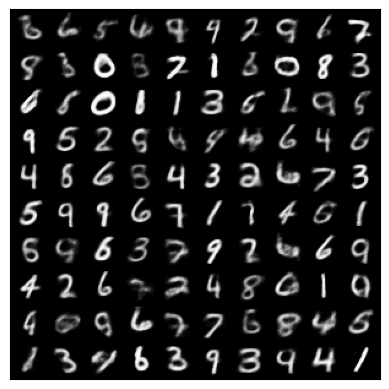

In [ ]:

unique_image_filename = f"vae_{datetime.utcnow()}.png"


def save_and_display_images(
    images, output_dir: str = output_dir, filename: str = "vae.png"
):
    """Save and display a grid of images.

    Args:
        images (torch.Tensor): A tensor of images to save and display.
        output_dir (str): The directory to save the images.
        filename (str): The filename to save the images as.

    Returns:
        None

    Displays:
        A grid of images.
    """
    save_image(images, output_dir + filename, nrow=10)
    display_images(make_grid(images, nrow=10))


vae_model = load_pretrained_vae(unique_filename, device)
generated_images = generate_images(
    vae_model,
    num_samples=100,
    z_dim=5,
    device=device,
)
save_and_display_images(generated_images, output_dir, unique_image_filename)

# 🥸 Generative Adversarial Network (GAN)

In this next step, we'll set up and run a Generative Adversarial Network (GAN). We'll create discriminator and a generator, and train this model to be able to tell the difference between real and fake images.

[To learn more about GANs, checkout the relevant section in the course content!](https://uplimit.com/course/stable-diffusion/v2/module/generative-adversarial-networks-gans#corise_clu9tgwjj0017356snjlrw6up)

## Set Up Discriminator


The Discrimator model takes a flattened image as input and processes it through a series of transformations and
non-linear activations to ultimately output a single value representing the likelihood that the input image is real.

In [17]:
class Discriminator(nn.Module):
    """The Discriminator network for the GAN model.

    Args:
        nn (nn.Module): The base class for all neural network modules
    """

    def __init__(self):
        """Initialize the Discriminator network with the following layers:

        1. Linear layer with 784 input features and 1024 output features
        2. LeakyReLU activation function with a slope of 0.2
        3. Dropout layer with a probability of 0.3
        4. Linear layer with 1024 input features and 512 output features
        5. LeakyReLU activation function with a slope of 0.2
        6. Dropout layer with a probability of 0.3
        7. Linear layer with 512 input features and 256 output features
        8. LeakyReLU activation function with a slope of 0.2
        9. Dropout layer with a probability of 0.3
        10. Linear layer with 256 input features and 1 output feature
        11. Sigmoid activation function

        Args:
            None

        Returns:
            None
        """
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Discriminator network

        Args:
            x (torch.Tensor): The input tensor

        Returns:
            prediction(torch.Tensor): The output prediction
        """
        x = x.view(x.size(first_dimension), 784)
        prediction = self.model(x).squeeze()
        return prediction

## Set Up Generator

The Generator takes a latent vector as input and processes it through a series of transformations and non-linear activations to
ultimately output a generated (or fake) image.

In [18]:
class Generator(nn.Module):
    """The Generator network for the GAN model.

    Args:
        nn (nn.Module): The base class for all neural network modules
    """

    def __init__(self):
        """Initialize the Generator network by setting up a sequential neural network with the following layers:

        1. Linear layer with 100 input features and 256 output features
        2. LeakyReLU activation function with a slope of 0.2
        3. Linear layer with 256 input features and 512 output features
        4. LeakyReLU activation function with a slope of 0.2
        5. Linear layer with 512 input features and 1024 output features
        6. LeakyReLU activation function with a slope of 0.2
        7. Linear layer with 1024 input features and 784 output features
        8. Tanh activation function to scale the output to the range (-1, 1)
        """

        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor):
        """Forward pass of the Generator network

        Args:
            z (torch.Tensor): The input tensor

        Returns:
            x_hat: The output tensor
        """
        batch_size = z.size(first_dimension)
        z = z.view(batch_size, number_of_dimensions)
        x_hat = self.model(z)
        return x_hat.view(batch_size, image_height, image_width)

## Set Up Generator Training

In this step, we set up a function that trains our generator by creating fake images, shows them to the discriminator to determine validity, and tries to game the discriminator by making fake images closer to real images.


In [19]:
def generator_train_step(
    batch_size: int,
    discriminator: Discriminator,
    generator: Generator,
    g_optimizer: torch.optim.Optimizer,
):
    """Train the generator network for one step

    Args:
        batch_size (int): usual x.shape[0]
        discriminator (Discriminator): The discriminator network
        generator (Generator): The generator network
        g_optimizer (torch.optim): The optimizer for the generator network

    Returns:
        g_loss.item(): The generator loss
    """
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, number_of_dimensions).to(device)
    fake_images = generator(z)
    validity = discriminator(fake_images)
    g_loss = nn.BCELoss(reduction="sum")(validity, torch.ones(batch_size).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

## Train Discriminator

Now, we're ready to train our discriminator! In this step, we show the fake images created by the generator, combined with real images from the training dataset to train the discriminator using standard classicification losses (BCE).

In [20]:
def discriminator_train_step(
    batch_size: int,
    discriminator: Discriminator,
    generator: Generator,
    d_optimizer: torch.optim.Optimizer,
    real_images: torch.Tensor,
    y: any # TODO: fill this in
):
    """Train the discriminator network for one step.
    The discriminator is trained to distinguish between real and fake images
    by minimizing the binary cross-entropy loss.

    Args:
        batch_size (int): usual x.shape[0]
        discriminator (nn.Module): The discriminator network
        generator (nn.Module): The generator network
        d_optimizer (torch.optim): The optimizer for the discriminator network
        real_images (torch.Tensor): The real images
        y (any): # TODO: fill this in

    Returns:
        d_loss.item(): The discriminator loss
    """
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images)
    real_loss = nn.BCELoss(reduction="sum")(
        real_validity, torch.ones(batch_size).to(device)
    )

    # train with fake images
    z = torch.randn(batch_size, number_of_dimensions).to(device)
    fake_images = generator(z)
    fake_validity = discriminator(fake_images)
    fake_loss = nn.BCELoss(reduction="sum")(
        fake_validity, torch.zeros(batch_size).to(device)
    )

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [24]:
def train_gan(
    generator: Generator,
    discriminator: Discriminator,
    train_dataloader: DataLoader,
    device: torch.device,
    num_epochs: int = 30,
    lr: float = 1e-4,
):
    """
    Train a Generative Adversarial Network (GAN).

    Args:
        generator (Generator): The generator network.
        discriminator (Discriminator): The discriminator network.
        train_dataloader (DataLoader): DataLoader for the training data.
        device (torch.device): The device to train on.
        num_epochs (int, optional): Number of epochs to train for. Defaults to 30.
        lr (float, optional): Learning rate for the optimizers. Defaults to 1e-4.
    """
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        d_loss = 0
        g_loss = 0
        for i, (x, y) in tqdm(
            enumerate(train_dataloader),
            desc=f"Epoch {epoch}",
            unit=" batches",
            total=len(train_dataloader),
            ncols=tqdm_ncols,
        ):
            x = x.to(device)
            y = y.to(device)
            generator.train()

            # TODO: Choose one from the following implementation to let the discriminator and generator to play the min-max game

            # 1: Train both discriminator and generator
            d_loss += discriminator_train_step(
                 x.shape[0], discriminator, generator, d_optimizer, x, y
             )
            g_loss += generator_train_step(
                 x.shape[0], discriminator, generator, g_optimizer
             )

            # 2: Train only the discriminator
            # d_loss += discriminator_train_step(
            #     x.shape[0], discriminator, generator, d_optimizer, x, y
            # )

            # 3: Train only the generator
            # g_loss += generator_train_step(
            #     x.shape[0], discriminator, generator, g_optimizer
            # )
        print(
            f"Discriminator Training Loss: {d_loss / len(train_dataloader.dataset):.4f}. "
            f"Generator Training Loss: {g_loss / len(train_dataloader.dataset):.4f}."
        )

    torch.save(generator.state_dict(), "gan_generator.pt")
    torch.save(discriminator.state_dict(), "gan_discriminator.pt")


generator = Generator().to(device)
discriminator = Discriminator().to(device)
train_gan(generator, discriminator, train_dataloader, device)

Epoch 0: 100%|██████████████████████████████████████████████| 938/938 [00:15<00:00, 62.42 batches/s]


Discriminator Training Loss: 1.1850. Generator Training Loss: 1.5211.


Epoch 1: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 63.27 batches/s]


Discriminator Training Loss: 0.8806. Generator Training Loss: 2.0375.


Epoch 2: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 65.80 batches/s]


Discriminator Training Loss: 0.5861. Generator Training Loss: 2.3992.


Epoch 3: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 64.85 batches/s]


Discriminator Training Loss: 0.6017. Generator Training Loss: 2.6336.


Epoch 4: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 64.16 batches/s]


Discriminator Training Loss: 0.5834. Generator Training Loss: 2.6562.


Epoch 5: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 64.68 batches/s]


Discriminator Training Loss: 0.5575. Generator Training Loss: 2.7770.


Epoch 6: 100%|██████████████████████████████████████████████| 938/938 [00:15<00:00, 62.29 batches/s]


Discriminator Training Loss: 0.4617. Generator Training Loss: 3.1073.


Epoch 7: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 65.91 batches/s]


Discriminator Training Loss: 0.4814. Generator Training Loss: 3.0981.


Epoch 8: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 63.83 batches/s]


Discriminator Training Loss: 0.4341. Generator Training Loss: 3.2703.


Epoch 9: 100%|██████████████████████████████████████████████| 938/938 [00:14<00:00, 64.76 batches/s]


Discriminator Training Loss: 0.4431. Generator Training Loss: 3.1391.


Epoch 10: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.62 batches/s]


Discriminator Training Loss: 0.4144. Generator Training Loss: 3.2252.


Epoch 11: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 66.21 batches/s]


Discriminator Training Loss: 0.4019. Generator Training Loss: 3.3644.


Epoch 12: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.71 batches/s]


Discriminator Training Loss: 0.3864. Generator Training Loss: 3.3440.


Epoch 13: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.13 batches/s]


Discriminator Training Loss: 0.3716. Generator Training Loss: 3.5548.


Epoch 14: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 63.96 batches/s]


Discriminator Training Loss: 0.3628. Generator Training Loss: 3.5557.


Epoch 15: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 66.11 batches/s]


Discriminator Training Loss: 0.3511. Generator Training Loss: 3.5643.


Epoch 16: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 66.09 batches/s]


Discriminator Training Loss: 0.3425. Generator Training Loss: 3.7347.


Epoch 17: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.83 batches/s]


Discriminator Training Loss: 0.3316. Generator Training Loss: 3.7366.


Epoch 18: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 66.01 batches/s]


Discriminator Training Loss: 0.3225. Generator Training Loss: 3.8538.


Epoch 19: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 63.82 batches/s]


Discriminator Training Loss: 0.3015. Generator Training Loss: 3.9397.


Epoch 20: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 66.17 batches/s]


Discriminator Training Loss: 0.2897. Generator Training Loss: 4.1345.


Epoch 21: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.24 batches/s]


Discriminator Training Loss: 0.2900. Generator Training Loss: 4.1006.


Epoch 22: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 66.38 batches/s]


Discriminator Training Loss: 0.2865. Generator Training Loss: 4.1353.


Epoch 23: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.99 batches/s]


Discriminator Training Loss: 0.2810. Generator Training Loss: 4.1919.


Epoch 24: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 64.01 batches/s]


Discriminator Training Loss: 0.2875. Generator Training Loss: 4.2584.


Epoch 25: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 62.56 batches/s]


Discriminator Training Loss: 0.2765. Generator Training Loss: 4.2384.


Epoch 26: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 64.96 batches/s]


Discriminator Training Loss: 0.2810. Generator Training Loss: 4.2224.


Epoch 27: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.70 batches/s]


Discriminator Training Loss: 0.2713. Generator Training Loss: 4.3430.


Epoch 28: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 65.94 batches/s]


Discriminator Training Loss: 0.2638. Generator Training Loss: 4.4208.


Epoch 29: 100%|█████████████████████████████████████████████| 938/938 [00:14<00:00, 63.21 batches/s]

Discriminator Training Loss: 0.2600. Generator Training Loss: 4.4266.


## Run Generative Adversarial Network

Finally, we're ready to run our GAN!

In this step, we set up Adam optimizers for both the Discrimator and the Generator, in order to minimize the respective loss functions for each. Then, in each epoch, the discriminator is trained first, followed by the generator, so they'd play the min-max game until convergence.

The output of both the Discriminator and the Generator is saved to a location where we can review it!

## ↪️ Your Turn: Review Results

What do you notice about the images generated by the GAN?

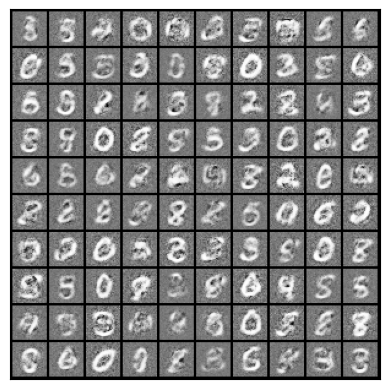

In [25]:
z = torch.randn(100, 100).to(device)
images = generator(z).unsqueeze(1)
save_image(images, "./output/gan.png", nrow=10)
display_images(make_grid(images, nrow=10, normalize=True))

# 🗜️🔮Conditional Variational Autoencoder (CVAE)

CVAEs extend VAEs by incorporating conditional information into the autoencoding process. This conditional information could be anything relevant to the task at hand, such as labels in a classification task, or part of the data in a prediction task.

The key idea is that both the encoder and decoder of a CVAE are conditioned on this additional information, which allows the model to generate data that's not just plausible but also specific to the given condition.

First, we initialize our Conditional Decoder and set up the forward pass function simplifies the complex information in an image down to a tensor over which the model can operate.

In [26]:
class ConditionalDecoder(nn.Module):
    """The Conditional Decoder network for the Conditional VAE model.
    The decoder decodes the latent vector z back into an reconstruction of x, x_hat.

    Args:
        nn (nn.Module): The base class for all neural network modules
    """

    def __init__(
        self, x_dim: int = 784, h_dim1: int = 512, h_dim2: int = 256, z_dim: int = 5
    ):
        """Initialize the Conditional Decoder network

        Args:
            x_dim (int): The dimension of the input x
            h_dim1 (int): The dimension of the first hidden layer
            h_dim2 (int): The dimension of the second hidden layer
            z_dim (int): The dimension of the latent vector z
        """
        super().__init__()
        self.num_classes = 10
        self.fc1 = nn.Linear(z_dim + self.num_classes, h_dim2)
        self.fc2 = nn.Linear(h_dim2, h_dim1)
        self.fc3 = nn.Linear(h_dim1, x_dim)

    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Conditional Decoder network

        Args:
            z (torch.Tensor): The latent vector z
            y (torch.Tensor): The condition tensor

        Returns:
            x_hat (torch.Tensor): The reconstructed input x_hat
        """
        condition = nn.functional.one_hot(y, num_classes=self.num_classes).type(
            torch.float
        )
        # TODO: z is the latent z concated with the condition along dim 1. This is the trick to make the decoder
        # reconstruction generate a specific digit.
        z = torch.cat([z,condition], dim=1)
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_hat = F.sigmoid(self.fc3(h))
        return x_hat

Next, we set up our Conditional VAE model, initializing our encoder and decoder, as well as setting up the forward pass function that allows us to sample latent space and reconstruct the input data.

In [27]:
class ConditionalVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        """_summary_

        Args:
            x_dim (int): The dimension of the input x
            h_dim1 (int): The dimension of the first hidden layer
            h_dim2 (int): The dimension of the second hidden layer
            z_dim (int): The dimension of the latent vector z
        """
        super().__init__()
        self.encoder = Encoder(x_dim, h_dim1, h_dim2, z_dim)
        self.decoder = ConditionalDecoder(x_dim, h_dim1, h_dim2, z_dim)

    def forward(
        self, x: torch.Tensor, y: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """_summary_

        Args:
            x (torch.Tensor): input tensor
            y (torch.Tensor): condition tensor

        Returns:
            x_hat (torch.Tensor): The reconstructed input x_hat
            mean (torch.Tensor): The mean of the latent vector z
            log_variance (torch.Tensor): The log of the variance of the latent vector z
        """
        z, mean, log_variance = self.encoder(x.view(-1, 784))
        x_hat = self.decoder(z, y)
        return x_hat, mean, log_variance

## Train Conditional Variational Autoencoder

Finally, we're ready to train our CVAE! In each epoch, we update weights to minimize training loss.

In [28]:
def train_cvae(epoch: int, optimizer: torch.optim.Optimizer, cvae: ConditionalVAE):
    """Train the Conditional Variational Autoencoder model for one epoch

    Args:
        epoch (int): The current epoch number
        optimizer (torch.optim.Optimizer): The optimizer to update the model's parameters
        cvae (ConditionalVAE): The Conditional VAE model to train

    Returns:
        None

    Displays:
        Training Average Loss

    """
    cvae.train()
    train_loss = 0
    for batch_idx, (x, y) in tqdm(
        enumerate(train_dataloader),
        desc="Epoch {}".format(epoch),
        unit=" batches",
        total=len(train_dataloader),
        ncols=tqdm_ncols,
    ):
        x = x.to(device)
        y = y.to(device)
        x = x.view(x.shape[0], -1)

        optimizer.zero_grad()

        x_hat, mean, log_variance = cvae(x, y)
        loss = vae_loss_function(x_hat, x, mean, log_variance)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(
        "Training Average Loss: {:.4f}".format(
            train_loss / len(train_dataloader.dataset)
        )
    )

## Test Conditional Variational Autoencoder

Next, we set up the function to test the Conditional Variational Autoencoder by evaluating it against the test data and computing average loss.

In [29]:
def test_cvae(cvae):
    """Test the CVAE model by computing the average loss on the test dataset

    Args:
        cvae (ConditionalVAE): The conditional variational autoencoder model

    Returns:
        None

    Displays:
        Test Average Loss

    """
    cvae.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            x = x.view(x.shape[0], -1)
            x_hat, mean, log_variance = cvae(x, y)

            # sum up batch loss
            test_loss += vae_loss_function(x_hat, x, mean, log_variance).item()

    print("Test Average Loss: {:.4f}".format(test_loss / len(test_dataloader.dataset)))

## Run Conditional Variational Autoencoder

Finally, we run Conditional Variational Autoencoder for 10 epochs, training and testing in each epoch. The state of the CVAE is saved for us to review!

In [30]:
def run_cvae_training(
    x_dim: int = 784,
    h_dim1: int = 512,
    h_dim2: int = 256,
    z_dim: int = 5,
    num_epochs: int = 10,
    device: torch.device = torch.device("cpu"),
    save_path: str = "cvae.pt",
):
    """Run the Conditional Variational Autoencoder model

    Args:
        x_dim (int): The dimension of the input x
        h_dim1 (int): The dimension of the first hidden layer
        h_dim2 (int): The dimension of the second hidden layer
        z_dim (int): The dimension of the latent vector z
        num_epochs (int): number of epochs to train for
        device (torch.device): device to train on
        save_path (str): place we want to save the model output

    Returns:
        None, but saves the output to the path specified in save_path

    """
    cvae = ConditionalVAE(x_dim=x_dim, h_dim1=h_dim1, h_dim2=h_dim2, z_dim=z_dim)
    cvae.to(device)

    # Optimizer
    cvae_optimizer = optim.Adam(cvae.parameters())

    for epoch in range(1, num_epochs + 1):
        train_cvae(epoch, cvae_optimizer, cvae)
        test_cvae(cvae)

    torch.save(cvae.state_dict(), save_path)


run_cvae_training(
    x_dim=784,
    h_dim1=512,
    h_dim2=256,
    z_dim=5,
    num_epochs=10,
    device=device,
    save_path="cvae.pt",
)

Epoch 1: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 97.65 batches/s]


Training Average Loss: 149.7480
Test Average Loss: 126.4967


Epoch 2: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 95.96 batches/s]


Training Average Loss: 122.8694
Test Average Loss: 119.0591


Epoch 3: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 96.35 batches/s]


Training Average Loss: 117.9156
Test Average Loss: 115.8000


Epoch 4: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 97.24 batches/s]


Training Average Loss: 115.1398
Test Average Loss: 115.0968


Epoch 5: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 96.37 batches/s]


Training Average Loss: 113.4690
Test Average Loss: 113.2749


Epoch 6: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 96.34 batches/s]


Training Average Loss: 112.1870
Test Average Loss: 112.0916


Epoch 7: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 96.64 batches/s]


Training Average Loss: 111.2235
Test Average Loss: 111.9573


Epoch 8: 100%|██████████████████████████████████████████████| 938/938 [00:09<00:00, 97.44 batches/s]


Training Average Loss: 110.5071
Test Average Loss: 111.4221


Epoch 9: 100%|█████████████████████████████████████████████| 938/938 [00:09<00:00, 100.84 batches/s]


Training Average Loss: 109.8464
Test Average Loss: 110.9583


Epoch 10: 100%|████████████████████████████████████████████| 938/938 [00:09<00:00, 102.33 batches/s]


Training Average Loss: 109.3721
Test Average Loss: 110.6371


## ↪️ Your Turn: Review Results

What do you notice about the images generated by the CVAE?

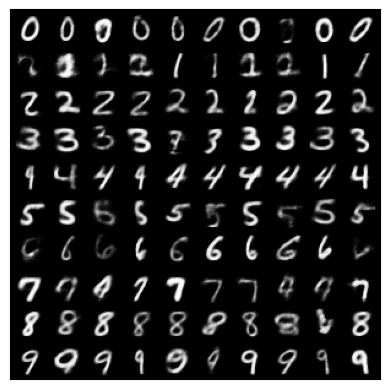

In [31]:
def generate_and_save_cvae_images(
    model_path: str = "cvae.pt",
    output_dir: str = "./output",
    device: torch.device = torch.device("cpu"),
    num_samples: int = 100,
    z_dim: int = 5,
    image_dim: Tuple = preferred_image_dimensions,
    nrow: int = 10,
):
    """
    Load a pre-trained CVAE model, generate images, and save them to a file.

    Args:
        model_path (str): Path to the pre-trained CVAE model file.
        output_dir (str): Directory to save the generated images.
        device (torch.device): Device to run the model on (CPU or GPU).
        num_samples (int): Number of images to generate.
        z_dim (int): Dimension of the latent space.
        image_dim (tuple): Dimensions of the generated images.
        nrow (int): Number of images in each row of the grid.
    """
    # Load the pre-trained model
    cvae = ConditionalVAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=z_dim)
    cvae.load_state_dict(torch.load(model_path, map_location=device))
    cvae.to(device)
    cvae.eval()

    # Generate latent vectors and corresponding labels
    z = torch.randn(num_samples, z_dim).to(device)
    y = torch.tensor(range(num_samples)).to(device) // (num_samples // 10)

    # Generate images
    with torch.no_grad():
        sample = cvae.decoder(z, y).to(device)

    # Save and display images
    filename = os.path.join(output_dir, "cvae.png")
    save_image(sample.view(num_samples, *image_dim), filename, nrow=nrow)
    display_images(make_grid(sample.view(num_samples, *image_dim), nrow=nrow))


generate_and_save_cvae_images(
    model_path="cvae.pt",
    output_dir=output_dir,
    device=device,
)

# 🗜️🥸 Conditional Generative Adversarial Network (CGAN)

In the context of image generation history, CGANs are particularly useful in scenarios where the generated data needs to satisfy specific conditions or attributes. For example, in image generation, a CGAN can generate images of animals conditioned on species labels, so you can control which type of animal image the model generates. Similarly, in style transfer applications, the conditional information can specify the desired style for the generated image.

## Set Up Conditioned Discriminator

First, we'll set up a conditioned discriminator comprised of sequential neural network. The conditioned discriminator takes the input tensor and the condition and makes a prediction about whether an image is real or fake.

In [32]:
class ConditionedDiscriminator(nn.Module):
    """The Conditioned Discriminator network for the Conditional GAN model

    Args:
        nn (nn.Module): The base class for all neural network modules
    """

    def __init__(self):
        """Initialize the Conditioned Discriminator network by setting up a sequential neural network with the following layers:

        1. Linear layer with 794 input features and 1024 output features
        2. LeakyReLU activation function with a slope of 0.2
        3. Dropout layer with a probability of 0.3
        4. Linear layer with 1024 input features and 512 output features
        5. LeakyReLU activation function with a slope of 0.2
        6. Dropout layer with a probability of 0.3
        7. Linear layer with 512 input features and 256 output features
        8. LeakyReLU activation function with a slope of 0.2
        9. Dropout layer with a probability of 0.3
        10. Linear layer with 256 input features and 1 output feature
        11. Sigmoid activation function to scale the output to the range (0, 1)
        """
        super().__init__()

        self.y_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Conditioned Discriminator network

        Args:
            x (torch.Tensor): The input tensor
            y (torch.Tensor): The condition tensor

        Returns:
            prediction (torch.Tensor): The output prediction
        """
        x = x.view(x.size(0), 784)
        condition = self.y_emb(y)
        # TODO: The discriminator needs to know which condition is used so that it can use that information to tell whether the image is real or fake.
        # x is the x concated with the condition along dim 1.
        x = torch.cat([x,condition], dim=1)
        prediction = self.model(x).squeeze()
        return prediction

## Set Up Conditioned Generator

Next, we set up a conditioned generator. The conditioned generator is sequential neural network that takes the input data and the condition and generates returns a reconstructed version of the input data.

In [33]:
class ConditionedGenerator(nn.Module):
    """The Conditioned Generator network for the Conditional GAN model

    Args:
        nn (nn.Module): The base class for all neural network modules
    """

    def __init__(self):
        """Initialize the Conditioned Generator network by setting up a sequential neural network with the following layers:

        1. Linear layer with 110 input features and 256 output features
        2. LeakyReLU activation function with a slope of 0.2
        3. Linear layer with 256 input features and 512 output features
        4. LeakyReLU activation function with a slope of 0.2
        5. Linear layer with 512 input features and 1024 output features
        6. LeakyReLU activation function with a slope of 0.2
        7. Linear layer with 1024 input features and 784 output features
        8. Tanh activation function to scale the output to the range (-1, 1)
        """
        super().__init__()

        self.y_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Conditioned Generator network

        Args:
            z (torch.Tensor): The input tensor
            y (torch.Tensor): The condition tensor

        Returns:
            x_hat (torch.Tensor): The output tensor
        """
        z = z.view(z.size(first_dimension), number_of_dimensions)
        condition = self.y_emb(y)
        # TODO: The generator needs to know which digit to generate.
        # z is the z concated with the condition along dim 1.
        z = torch.cat([z,condition], dim=1)
        x_hat = self.model(z)
        return x_hat.view(z.size(first_dimension), image_height, image_width)

## Train Conditioned Generator

In this step, we set up a function that trains our conditioned generator by creating fake images, shows them to the discriminator to determine validity, and tries to game the discriminator by making fake images closer to real images.

In [34]:
def generator_train_step(
    batch_size: int,
    discriminator: ConditionedDiscriminator,
    generator: ConditionedGenerator,
    g_optimizer: torch.optim.Optimizer,
):
    """Train the conditioned generator network for one step

    Args:
        batch_size (int): usual x.shape[0]
        discriminator (ConditionedDiscriminator): The conditioned discriminator network
        generator (ConditionedGenerator): The conditioned generator network
        g_optimizer (torch.optim): The optimizer for the conditioned generator network

    Returns:
        g_loss.item(): The conditioned generator loss
    """
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, number_of_dimensions).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = nn.BCELoss()(validity, torch.ones(batch_size).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

## Train Conditioned Discriminator

Now, we're ready to train our discriminator! In this step, we show the fake images created by the generator, combined with real images from the training dataset to train the discriminator using standard classicification losses (BCE).

In [35]:
def discriminator_train_step(
    batch_size: int,
    discriminator: ConditionedDiscriminator,
    generator: ConditionedGenerator,
    d_optimizer: torch.optim.Optimizer,
    real_images: torch.Tensor,
    labels: torch.LongTensor,
):
    """Train the conditioned discriminator network for one step

    Args:

        batch_size (int): usual x.shape[0]
        discriminator (ConditionedDiscriminator): The conditioned discriminator network
        generator (ConditionedGenerator): The conditioned generator network
        d_optimizer (torch.optim): The optimizer for the conditioned discriminator network
        real_images (torch.Tensor): The real images
        labels (torch.LongTensor): The labels for the real images

    Returns:
        d_loss.item(): The conditioned discriminator loss
    """
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = nn.BCELoss()(real_validity, torch.ones(batch_size).to(device))

    # train with fake images
    z = torch.randn(batch_size, number_of_dimensions).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = nn.BCELoss()(fake_validity, torch.zeros(batch_size).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

## Run Conditioned Generative Adversarial Network

Finally, we're ready to run our CGAN! 🎉

In [36]:
conditioned_generator = ConditionedGenerator().to(device)
conditioned_discriminator = ConditionedDiscriminator().to(device)

In [37]:
def train_conditioned_gan(
    conditioned_generator: ConditionedGenerator,
    conditioned_discriminator: ConditionedDiscriminator,
    train_dataloader: DataLoader,
    device: torch.device,
    num_epochs: int = 50,
    n_critic: int = 5,
    lr: float = 1e-4,
    tqdm_ncols: int = 100,
    save_paths: str = ("cgan_generator.pt", "cgan_discriminator.pt"),
):
    """Train a Conditional Generative Adversarial Network (CGAN).

    Args:

        conditioned_generator (ConditionedGenerator): The conditioned generator network.
        conditioned_discriminator (ConditionedDiscriminator): The conditioned discriminator network.
        train_dataloader (DataLoader): DataLoader for the training data.
        device (torch.device): The device to train on.
        num_epochs (int, optional): Number of epochs to train for. Defaults to 50.
        n_critic (int, optional): Number of discriminator updates per generator update. Defaults to 5.
        lr (float, optional): Learning rate for the optimizers. Defaults to 1e-4.
        tqdm_ncols (int, optional): Number of columns for tqdm. Defaults to 100.
        save_paths (str, optional): Paths to save the generator and discriminator models. Defaults to ("cgan_generator.pt", "cgan_discriminator.pt").

    Returns:
        None, but saves the output to the paths specified in save_paths

    Displays:
        Discriminator Training Loss
        Generator Training Loss

    """

    d_optimizer = torch.optim.Adam(conditioned_discriminator.parameters(), lr=1e-4)
    g_optimizer = torch.optim.Adam(conditioned_generator.parameters(), lr=1e-4)


    for epoch in range(num_epochs):
        d_loss = 0
        g_loss = 0
        for i, (x, y) in tqdm(enumerate(train_dataloader), desc = "Epoch {}".format(epoch), unit =" batches", total = len(train_dataloader), ncols = tqdm_ncols):
            x = x.to(device)
            y = y.to(device)
            generator.train()

            for _ in range(n_critic):
                d_step_loss = discriminator_train_step(x.shape[0], conditioned_discriminator, conditioned_generator, d_optimizer, x, y)
            d_loss += d_step_loss
            g_loss += generator_train_step(x.shape[0], conditioned_discriminator, conditioned_generator, g_optimizer)
        print('Discriminator Training Loss: {:.4f}. Generator Training Loss: {:.4f}'.format(d_loss / len(train_dataloader.dataset), g_loss / len(train_dataloader.dataset)))

    return conditioned_generator, conditioned_discriminator



In [38]:
conditioned_generator, conditioned_discriminator = train_conditioned_gan(conditioned_generator, conditioned_discriminator, train_dataloader, device)

torch.save(conditioned_generator.state_dict(), 'cgan_generator.pt')
torch.save(conditioned_discriminator.state_dict(), 'cgan_discriminator.pt')

Epoch 0: 100%|██████████████████████████████████████████████| 938/938 [00:36<00:00, 25.76 batches/s]


Discriminator Training Loss: 0.0005. Generator Training Loss: 0.1370


Epoch 1: 100%|██████████████████████████████████████████████| 938/938 [00:35<00:00, 26.50 batches/s]


Discriminator Training Loss: 0.0001. Generator Training Loss: 0.1771


Epoch 2: 100%|██████████████████████████████████████████████| 938/938 [00:35<00:00, 26.66 batches/s]


Discriminator Training Loss: 0.0001. Generator Training Loss: 0.1881


Epoch 3: 100%|██████████████████████████████████████████████| 938/938 [00:35<00:00, 26.76 batches/s]


Discriminator Training Loss: 0.0002. Generator Training Loss: 0.1842


Epoch 4: 100%|██████████████████████████████████████████████| 938/938 [00:35<00:00, 26.79 batches/s]


Discriminator Training Loss: 0.0003. Generator Training Loss: 0.1729


Epoch 5: 100%|██████████████████████████████████████████████| 938/938 [00:34<00:00, 26.81 batches/s]


Discriminator Training Loss: 0.0004. Generator Training Loss: 0.1581


Epoch 6: 100%|██████████████████████████████████████████████| 938/938 [00:34<00:00, 26.83 batches/s]


Discriminator Training Loss: 0.0004. Generator Training Loss: 0.1537


Epoch 7: 100%|██████████████████████████████████████████████| 938/938 [00:34<00:00, 26.81 batches/s]


Discriminator Training Loss: 0.0004. Generator Training Loss: 0.1487


Epoch 8: 100%|██████████████████████████████████████████████| 938/938 [00:35<00:00, 26.25 batches/s]


Discriminator Training Loss: 0.0005. Generator Training Loss: 0.1449


Epoch 9: 100%|██████████████████████████████████████████████| 938/938 [00:34<00:00, 26.92 batches/s]


Discriminator Training Loss: 0.0005. Generator Training Loss: 0.1460


Epoch 10: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.81 batches/s]


Discriminator Training Loss: 0.0004. Generator Training Loss: 0.1489


Epoch 11: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.87 batches/s]


Discriminator Training Loss: 0.0005. Generator Training Loss: 0.1492


Epoch 12: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.83 batches/s]


Discriminator Training Loss: 0.0004. Generator Training Loss: 0.1487


Epoch 13: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.48 batches/s]


Discriminator Training Loss: 0.0004. Generator Training Loss: 0.1443


Epoch 14: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.90 batches/s]


Discriminator Training Loss: 0.0004. Generator Training Loss: 0.1427


Epoch 15: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.74 batches/s]


Discriminator Training Loss: 0.0005. Generator Training Loss: 0.1414


Epoch 16: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.43 batches/s]


Discriminator Training Loss: 0.0005. Generator Training Loss: 0.1396


Epoch 17: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.90 batches/s]


Discriminator Training Loss: 0.0005. Generator Training Loss: 0.1401


Epoch 18: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.75 batches/s]


Discriminator Training Loss: 0.0006. Generator Training Loss: 0.1380


Epoch 19: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.80 batches/s]


Discriminator Training Loss: 0.0007. Generator Training Loss: 0.1361


Epoch 20: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.64 batches/s]


Discriminator Training Loss: 0.0006. Generator Training Loss: 0.1364


Epoch 21: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.78 batches/s]


Discriminator Training Loss: 0.0007. Generator Training Loss: 0.1341


Epoch 22: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.40 batches/s]


Discriminator Training Loss: 0.0007. Generator Training Loss: 0.1336


Epoch 23: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.75 batches/s]


Discriminator Training Loss: 0.0007. Generator Training Loss: 0.1315


Epoch 24: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.18 batches/s]


Discriminator Training Loss: 0.0007. Generator Training Loss: 0.1312


Epoch 25: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.76 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1279


Epoch 26: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.80 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1294


Epoch 27: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.91 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1288


Epoch 28: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 27.03 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1262


Epoch 29: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.92 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1300


Epoch 30: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.79 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1323


Epoch 31: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.69 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1324


Epoch 32: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.28 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1310


Epoch 33: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.67 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1337


Epoch 34: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.64 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1291


Epoch 35: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.68 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1282


Epoch 36: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.60 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1331


Epoch 37: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.64 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1329


Epoch 38: 100%|█████████████████████████████████████████████| 938/938 [00:34<00:00, 26.86 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1296


Epoch 39: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.51 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1294


Epoch 40: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.60 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1263


Epoch 41: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.69 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1316


Epoch 42: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.62 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1280


Epoch 43: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.62 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1294


Epoch 44: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.58 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1341


Epoch 45: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.72 batches/s]


Discriminator Training Loss: 0.0009. Generator Training Loss: 0.1258


Epoch 46: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.57 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1256


Epoch 47: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.63 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1275


Epoch 48: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.60 batches/s]


Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1249


Epoch 49: 100%|█████████████████████████████████████████████| 938/938 [00:35<00:00, 26.42 batches/s]

Discriminator Training Loss: 0.0008. Generator Training Loss: 0.1286


## ↪️ Your Turn: Review Results

Review the images generated by the CGAN. What do you notice?

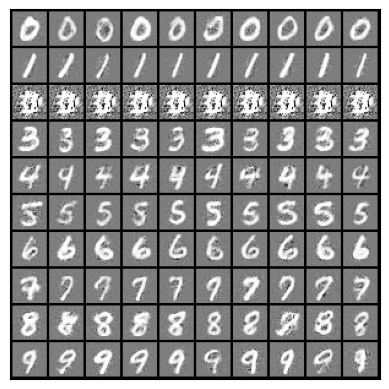

In [39]:
z = torch.randn(100, 100).to(device)
y = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)
images = conditioned_generator(z, y).unsqueeze(1)
save_image(images, "./output/cgan.png", nrow=10)
display_images(make_grid(images, nrow=10, normalize=True))

# ✨ Stable Diffusion

Congratulations on [speedrunning](https://en.wikipedia.org/wiki/Speedrunning) image generation! 🏎️

At last we've arrived at Stable Diffusion, a state of the art (SOTA) technique that generates detailed, high-quality images from textual descriptions, almost "like magic."

## Set Up Model Building Blocks



In [40]:
class ResidualConvBlock(nn.Module):
    """A standard ResNet style convolutional block

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        """
        Standard ResNet style convolutional block

        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            is_res (bool): whether to use residual connection

        Returns:
            None
        """
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Residual Convolutional Block

        Args:
            x (torch.Tensor): input tensor

        Returns:
            out or x2 (torch.Tensor): output tensor
        """
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

## Set Up Embeddings

This is a simple matrix multiplication embedding layer followed by a GELU and another matrix multiplicaiton.

In [41]:
class Embedding(nn.Module):
    """Embedding layer for the categorical input

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(self, input_dim: int, emb_dim: int):
        super().__init__()
        """
        Generic one layer FC NN for embedding things

        Args:
            input_dim (int): number of input features
            emb_dim (int): number of output features

        Returns:
            None
        """
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Embedding layer

        Args:
            x (torch.Tensor): the input tensor

        Returns:
            torch.Tensor: the output tensor
        """
        x = x.view(-1, self.input_dim)
        return self.model(x)

## Implement U-Nets

This next section is a spiritual implementation of [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

![img](https://lh7-us.googleusercontent.com/uULs_wiuuyvjoZMbGs2yYOXwWuKZNlbM0LG7iMsNK6Swt9y7HAufsWqbGxfyl6_39T_zEIPgqF9fPDEMFEYUG0JtuiX4ejvJgu5iwMM-taGSnuf63pu5-p4FW_ydUHdD2jkrPcyhlV04rV_r9fTzpD0)

In [42]:
class UnetDown(nn.Module):
    """Downsampling block for the U-Net architecture

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        """Process and downscale the image feature maps

        Args:

            in_channels (int): number of input channels
            out_channels (int): number of output channels

        Returns:
            None
        """
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Unet

        Args:
            x (torch.Tensor): the input tensor

        Returns:
            torch.Tensor: the output tensor
        """
        return self.model(x)


class UnetUp(nn.Module):
    """Upsampling block for the U-Net architecture

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        """Process and upscale the image feature maps with ConvTranspose2d network and residual convolutional blocks

        Args:

            in_channels (int): number of input channels
            out_channels (int): number of output channels

        Returns:
            None
        """
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        """Forward pass of the Unet

        Args:
            x (torch.Tensor): the input tensor
            skip (torch.Tensor): the skip connection tensor

        Returns:
            torch.Tensor: the output tensor
        """
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [43]:
class ContextUnet(nn.Module):
    """A U-Net architecture with context and time embeddings

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(self, in_channels: int, h_dim: int = 256, n_classes: int = 10):
        """Initialize a U-Net architecture with context and time embeddings

        Args:
            in_channels (int): number of input channels
            h_dim (int): number of hidden features
            n_classes (int): number of classes

        Returns:
            None
        """
        super().__init__()

        self.in_channels = in_channels
        self.h_dim = h_dim
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, h_dim, is_res=True)

        self.down1 = UnetDown(h_dim, h_dim)
        self.down2 = UnetDown(h_dim, 2 * h_dim)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = Embedding(1, 2 * h_dim)
        self.timeembed2 = Embedding(1, 1 * h_dim)
        self.contextembed1 = Embedding(n_classes, 2 * h_dim)
        self.contextembed2 = Embedding(n_classes, 1 * h_dim)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(
                2 * h_dim, 2 * h_dim, 7, 7
            ),
            nn.GroupNorm(8, 2 * h_dim),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * h_dim, h_dim)
        self.up2 = UnetUp(2 * h_dim, h_dim)
        self.out = nn.Sequential(
            nn.Conv2d(2 * h_dim, h_dim, 3, 1, 1),
            nn.GroupNorm(8, h_dim),
            nn.ReLU(),
            nn.Conv2d(h_dim, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        """Forward pass of the Context U-Net

        Args:
            x (torch.Tensor): the input tensor
            c (torch.Tensor): the context tensor
            t (torch.Tensor): the time tensor
            context_mask (torch.Tensor): the context mask tensor

        Returns:
            torch.Tensor: the output tensor
        """
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        z = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = -1 * (1 - context_mask)  # need to flip 0 <-> 1
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.h_dim * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.h_dim * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.h_dim, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.h_dim, 1, 1)

        up1 = self.up0(z)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1 * up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Conditional Image Generation with Diffusion Model Using MNIST

This script does conditional image generation on MNIST, using a diffusion model

This code is modified from,
https://github.com/cloneofsimo/minDiffusion

Diffusion model is based on DDPM,
https://arxiv.org/abs/2006.11239

The conditioning idea is taken from 'Classifier-Free Diffusion Guidance',
https://arxiv.org/abs/2207.12598

This technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Modelswith Deep Language Understanding',
https://arxiv.org/abs/2205.11487

In [44]:
def ddpm_schedules(beta1: float, beta2: float, T: int = 400) -> dict:
    """
    Returns pre-computed schedules for DDPM sampling, training process.

    Args:
        beta1 (float): initial value of beta1
        beta2 (float): final value of beta2
        T (int): number of iterations

    Returns:
        dict: dictionary containing the pre-computed schedules
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

### Denoising Diffusion Probabilistic Model (DDPM) Setup

In [45]:
class DDPM(nn.Module):
    """A Denoising Diffusion Probabilistic Model

    Args:
        nn (nn.Module): the base class for all neural network modules
    """

    def __init__(
        self,
        nn_model: nn.Module,
        betas: list[float],
        T: int,
        device: torch.device,
        drop_prob: float = 0.1,
    ):
        """Initialize the Denoising Diffusion Probabilistic Model

        Args:

            nn_model (nn.Module): the neural network model
            betas (list[float]): the beta values
            T (int): the number of iterations
            device (torch.device): the device to run the model on
            drop_prob (float): the dropout probability

        Returns:
            None. Sets up a register_buffer for the pre-computed schedules.
        """

        super().__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], T).items():
            self.register_buffer(k, v)

        self.T = T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        This method is used in training, so samples t and noise randomly

        Args:
            x (torch.Tensor): the input tensor
            c (torch.Tensor): the context tensor

        Returns:
            MSE loss between added noise and predicted noise
        """

        _ts = torch.randint(1, self.T + 1, (x.shape[0],)).to(
            self.device
        )  # t ~ Uniform(0, T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c) + self.drop_prob).to(
            self.device
        )

        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.T, context_mask))

    def sample(
        self, n_sample: int, size: int, device: torch.device, guide_w: float = 0.0
    ) -> Tuple[torch.Tensor, np.array]:
        """We follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
            to make the fwd passes efficient, we concat two versions of the dataset,
            one with context_mask=0 and the other context_mask=1
            we then mix the outputs with the guidance scale, w
            where w>0 means more guidance

        Args:
            n_sample (int): number of samples to generate
            size (int): size of the image
            device (torch.device): device to run the model on
            guide_w (float): the guidance scale

        Returns:
            x_i (torch.Tensor): the generated samples
            x_i_history (np.array): the generated samples history
        """

        x_i = torch.randn(n_sample, *size).to(
            device
        )  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0, 10).to(
            device
        )  # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample / c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1.0  # makes second half of batch context free

        x_i_history = []  # keep track of generated steps in case want to plot something
        print()
        for i in range(self.T, 0, -1):
            print(f"sampling timestep {i}", end="\r")
            t_is = torch.tensor([i / self.T]).to(device)
            t_is = t_is.repeat(n_sample, 1, 1, 1)

            # double batch
            x_i = x_i.repeat(2, 1, 1, 1)
            t_is = t_is.repeat(2, 1, 1, 1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i % 20 == 0 or i == self.T or i < 8:
                x_i_history.append(x_i.detach().cpu().numpy())

        x_i_history = np.array(x_i_history)
        return x_i, x_i_history

## Configure Hyperparameters

In [46]:
# Hyperparameters
n_epoch = 20
T = 400
h_dim = 128
lr = 1e-4
classifier_free_guide_weight = 2.0
n_classes = 10

## Run DDPM

In [47]:
def train_ddpm(
    ddpm: DDPM,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    n_epoch: int,
    lr: float,
    device: torch.device,
    tqdm_ncols: int = 100,
):
    """
    Train the Denoising Diffusion Probabilistic Model (DDPM).

    Args:
        ddpm (DDPM): The DDPM model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        train_dataloader (DataLoader): The DataLoader for training data.
        n_epoch (int): Number of epochs to train for.
        lr (float): Initial learning rate.
        device (torch.device): The device to train on.
        tqdm_ncols (int): Width of tqdm progress bar.

    Returns:
        None

    Displays:
        Training Loss
    """
    for epoch in range(n_epoch):
        ddpm.train()

        # Linear learning rate decay
        optimizer.param_groups[0]["lr"] = lr * (1 - epoch / n_epoch)

        epoch_loss = 0
        for x, c in tqdm(
            train_dataloader,
            desc=f"Epoch {epoch}",
            unit=" batches",
            total=len(train_dataloader),
            ncols=tqdm_ncols,
        ):
            optimizer.zero_grad()
            x = x.to(device)
            c = c.to(device)
            # TODO: the ddpm module computes the loss with the input x and the condition c. It needs to know
            # whether the image can be generated with the condition c. This is similar to conditional VAE.
            loss = ddpm(x, c)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"DDPM Training Loss: {epoch_loss / len(train_dataloader):.4f}.")


# Initialize the DDPM model
ddpm_model = DDPM(
    nn_model=ContextUnet(in_channels=1, h_dim=h_dim, n_classes=n_classes),
    betas=(1e-4, 0.02),
    T=T,
    device=device,
    drop_prob=0.1,
)
ddpm_model.to(device)

# Initialize the optimizer
ddpm_optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=lr)

# Train the model
train_ddpm(
    ddpm_model, ddpm_optimizer, train_dataloader, n_epoch, lr, device, tqdm_ncols
)

Epoch 0: 100%|██████████████████████████████████████████████| 938/938 [01:44<00:00,  8.96 batches/s]


DDPM Training Loss: 0.0530.


Epoch 1: 100%|██████████████████████████████████████████████| 938/938 [01:47<00:00,  8.72 batches/s]


DDPM Training Loss: 0.0320.


Epoch 2: 100%|██████████████████████████████████████████████| 938/938 [01:49<00:00,  8.56 batches/s]


DDPM Training Loss: 0.0289.


Epoch 3: 100%|██████████████████████████████████████████████| 938/938 [01:49<00:00,  8.53 batches/s]


DDPM Training Loss: 0.0275.


Epoch 4: 100%|██████████████████████████████████████████████| 938/938 [01:50<00:00,  8.48 batches/s]


DDPM Training Loss: 0.0264.


Epoch 5: 100%|██████████████████████████████████████████████| 938/938 [01:52<00:00,  8.31 batches/s]


DDPM Training Loss: 0.0256.


Epoch 6: 100%|██████████████████████████████████████████████| 938/938 [01:52<00:00,  8.34 batches/s]


DDPM Training Loss: 0.0251.


Epoch 7: 100%|██████████████████████████████████████████████| 938/938 [01:51<00:00,  8.40 batches/s]


DDPM Training Loss: 0.0247.


Epoch 8: 100%|██████████████████████████████████████████████| 938/938 [01:50<00:00,  8.46 batches/s]


DDPM Training Loss: 0.0243.


Epoch 9: 100%|██████████████████████████████████████████████| 938/938 [01:50<00:00,  8.47 batches/s]


DDPM Training Loss: 0.0240.


Epoch 10: 100%|█████████████████████████████████████████████| 938/938 [01:50<00:00,  8.48 batches/s]


DDPM Training Loss: 0.0238.


Epoch 11: 100%|█████████████████████████████████████████████| 938/938 [01:51<00:00,  8.39 batches/s]


DDPM Training Loss: 0.0236.


Epoch 12: 100%|█████████████████████████████████████████████| 938/938 [01:52<00:00,  8.32 batches/s]


DDPM Training Loss: 0.0232.


Epoch 13: 100%|█████████████████████████████████████████████| 938/938 [01:52<00:00,  8.33 batches/s]


DDPM Training Loss: 0.0231.


Epoch 14: 100%|█████████████████████████████████████████████| 938/938 [01:52<00:00,  8.32 batches/s]


DDPM Training Loss: 0.0231.


Epoch 15: 100%|█████████████████████████████████████████████| 938/938 [01:53<00:00,  8.30 batches/s]


DDPM Training Loss: 0.0226.


Epoch 16: 100%|█████████████████████████████████████████████| 938/938 [01:53<00:00,  8.29 batches/s]


DDPM Training Loss: 0.0227.


Epoch 17: 100%|█████████████████████████████████████████████| 938/938 [01:52<00:00,  8.34 batches/s]


DDPM Training Loss: 0.0224.


Epoch 18: 100%|█████████████████████████████████████████████| 938/938 [01:51<00:00,  8.44 batches/s]


DDPM Training Loss: 0.0222.


Epoch 19: 100%|█████████████████████████████████████████████| 938/938 [01:50<00:00,  8.48 batches/s]

DDPM Training Loss: 0.0223.


## Cleanup Cache & Notebook Environment

At this point, we may need to clean up our cache and also run Python's built-in garbage collector module, which can be use to release memory. If we don't do this, the following cell will run out of memory.

In [48]:
import gc

torch.cuda.empty_cache()
gc.collect()

6730

## Evaluate DDPM

Finally, it is time for us to evaluate the DDPM output! Review the images. What do you notice?

In [49]:
def evaluate_ddpm(
    ddpm: DDPM,
    n_classes: int,
    device: torch.device,
    classifier_free_guide_weight: float,
    output_dir: str = output_dir,
):
    """Evaluate the Denoising Diffusion Probabilistic Model (DDPM) by generating samples.

    Args:
        ddpm (DDPM): The trained DDPM model.
        n_classes (int): Number of classes.
        device (torch.device): Device to run the model on.
        classifier_free_guide_weight (float): The weight for classifier-free guidance.
        output_dir (str, optional): Location to save model output. Defaults to "./output/".

    Returns:
        None

    Displays:
        Generated Images
    """
    ddpm.eval()
    with torch.no_grad():
        n_sample = n_classes * n_classes
        x_hat, x_hat_history = ddpm.sample(
            n_sample, (1, image_height, image_width), device, guide_w=classifier_free_guide_weight
        )

        grid = make_grid(x_hat * -1 + 1, nrow=n_classes)
        save_image(grid, output_dir + "ddpm.png", nrow=n_classes)
        display_images(make_grid(x_hat.view(n_sample, 1, image_height, image_width), nrow=n_classes))

    return {"x_hat": x_hat, "x_hat_history": x_hat_history}

## Review DDPM Results

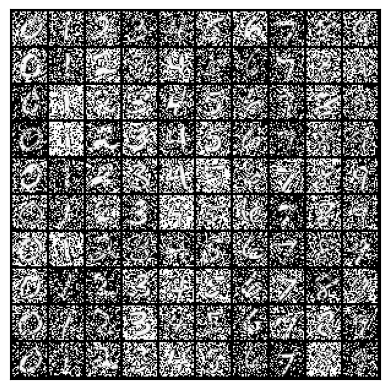

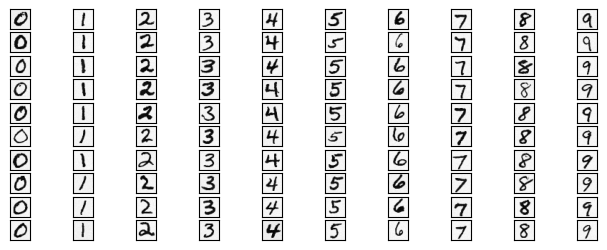

In [50]:
evaluation = evaluate_ddpm(
    ddpm_model,
    n_classes,
    device,
    classifier_free_guide_weight,
    output_dir=output_dir,
)


def create_ddpm_animation(
    x_hat_history, n_classes: int = 10, output_dir: str = output_dir
):
    """Create an animation of the generated samples from the Denoising Diffusion Probabilistic Model (DDPM).

    Args:
        x_hat_history (np.array): History of generated samples.
        n_classes (int): Number of classes.
        output_dir (str): Directory to save the animation.

    Returns:
        None

    Displays:
        Animation of the generated samples
    """
    fig, axs = plt.subplots(
        nrows=n_classes, ncols=n_classes, sharex=True, sharey=True, figsize=(8, 3)
    )

    def animate_diff(i, x_hat_history):
        plots = []
        for row in range(n_classes):
            for col in range(n_classes):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                img = -x_hat_history[i, (row * n_classes) + col, 0]
                plots.append(
                    axs[row, col].imshow(
                        img,
                        cmap="gray",
                        vmin=img.min(),
                        vmax=img.max(),
                    )
                )
        return plots

    animation = FuncAnimation(
        fig,
        animate_diff,
        fargs=(x_hat_history,),
        interval=200,
        blit=False,
        repeat=True,
        frames=x_hat_history.shape[0],
    )
    animation.save(output_dir + "ddpm.gif", dpi=100, writer=PillowWriter(fps=5))


create_ddpm_animation(evaluation["x_hat_history"], n_classes, output_dir)
torch.save(ddpm_model.state_dict(), output_dir + "ddpm.pt")

## ↪️ Your Turn: Reflect!

### What do you notice about the quality of the generated images with each method? Sum up your findings in your own words.

### How would you compare the quality, training, and generation run time for each method?



# 🗃️ References

- https://arxiv.org/pdf/1906.02691.pdf